# 3.6 Boston housing price (regression)

## *regression* --- predict a continuous value rather than a discrete label

## (Note: Don't confuse *regression* with *logistic regression*, logistic regression is a classification algorithm)

## In this example, we'll attempt to predict the median price of homes in a given Boston suburb in mid-1970s, given data points about the suburb at the time (including different features)

In [1]:
from keras.datasets import boston_housing 

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 0s 3us/step


### Compared to classification samples before, it has relatively few data points: only 506 (404 fro training, 102 for test samples)

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

### Each sample has 13 numerical features (e.g. crime rate, average room numbers per dwelling, accessibility to highways), and they might have different scales, some ranging from 0 to 1, some might be 1 to 12,  etc.  

In [5]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

### The targets are median prices of homes,  in thousands of dollars

In [6]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## 3.6.2 Preparing the data

### SImply feed the wildly ranging data into the neural network might be prooblematic: though the network can adapt to it, but it definitely makes the learning more difficult
### A widely used practice is *feature-wise normalization* :  for each feature in the input data (column),
$$ \frac{x - \mu}{\sigma}$$
### So that the feature is centered around 0 and has a unit standard deviation

In [7]:
mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std

test_data -= mean
test_data /= std

###  Note that the test data also normalized by the mean&std computed from the training data !!! We should never use any quantity computed on the test data in the workflow

## 3.6.3 Build the network

###  Because few examples are available, we will use a small network with two hidden layers, each with 64 units;
###  In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting

In [12]:
from keras import models
from keras import layers

# we define a function as we will use the same model multiple times
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1], )))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    
    return model

###  The network ends with a single unit and no activation (it will be a linear layer), a typical setup for scalar regression.
### Because applying an activation function would constrain the range the output can take (e.g. sigmoid: 0~1),  here the last layer is purely linear, the network is free to learn to predict values in any range

### Note here we compile the network with the *mse* loss function (mean squared error) and monitor a new metric: *mean absolute error* (MAE)

## 3.6.4 Validating using K-fold validation

### To evaluate the network while adjusting parameters, we could split the data into a training set and a validation set as we did before. 
### But because you have so few data points, the validation set would end up being very small (e.g. 100 samples), thus the validation scores might change a lot depending on which data points you choose for validation and training: the validation scores might have a high *variance* with regard to the validation split

### The best practice is *K-fold* cross-validation: split  data into K partitions, instantiating K identical models and training each one on K-1 partitions while evaluate on the remaining one partition. The validation score is then the average of the K validation scores obtained

In [13]:
# K-fold validation
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    # prepare the validation data
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    # prepare the training data
    partial_train_data = np.concatenate(
                         [train_data[:i * num_val_samples], train_data[(i+1) * num_val_samples:]], axis = 0)
    partial_train_targets = np.concatenate(
                            [train_targets[:i * num_val_samples], train_targets[(i+1) * num_val_samples:]],
                            axis = 0)
    
    # build the model(already compiled)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs = num_epochs, batch_size = 1, verbose = 0)  # verbose = 0(train the model in silent mode)
    
    # evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)

processing fold # 0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

processing fold # 1
processing fold # 2
processing fold # 3


In [14]:
all_scores

[2.1115760803222656, 2.639744520187378, 2.634554624557495, 2.2741804122924805]

In [15]:
np.mean(all_scores)

2.415013909339905

### The different runs do indeed show rather different validation scores, the average 2.4 is a much more reliable metric than any single score; In this case, you're off by $ \$2400$ on average, which is significant considering the price ranging from $ \$10,000$ to $ \$50,000$ 

### Let's train the network a bit longer: 500 epochs. To keep a record of how well the model does at each epoch, we'll modify the training loop to save the per-epoch validation score log

In [27]:
num_epochs = 500
all_mae_histories = []

# K-fold validation

for i in range(k):
    print('processing fold #', i)
    # prepare the validation data
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    # prepare the training data
    partial_train_data = np.concatenate(
                         [train_data[:i * num_val_samples], train_data[(i+1) * num_val_samples:]], axis = 0)
    partial_train_targets = np.concatenate(
                            [train_targets[:i * num_val_samples], train_targets[(i+1) * num_val_samples:]],
                            axis = 0)
    
    # build the model(already compiled)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data = (val_data, val_targets),
              epochs = num_epochs, batch_size = 1, verbose = 0)  # verbose = 0(train the model in silent mode)
    
    # evaluate the model on the validation data
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [29]:
history.history.keys()

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])

### we can then compute the average of the per-epoch MAE scores for all folds

In [30]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### Let's visualize this

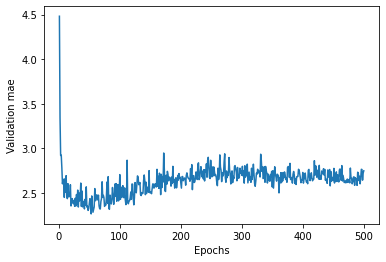

In [31]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation mae')
plt.show()

### It might be a little difficult to see the plot as scaling issues and relative high variances, let's modify it by:
### 1) Omit the first 10 data points, which are on a different scale than the rest of the curve;
### 2) Replace each point with an exponential moving average of the previous points, to obtain a smooth curve

In [32]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

In [33]:
# remove the first 10 points
smooth_mae_history = smooth_curve(average_mae_history[10:])

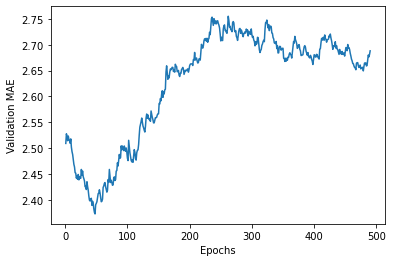

In [34]:
plt.clf()

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### According to the plot, validation MAE stops improving significantly after 80 epochs: past that point, we are overfitting
###  Once we' ve finished tuning other parameters of the model (e.g. size of hidden layers),  we can train a final production model on all of the training data, with the best parameters

In [35]:
model = build_model()
model.fit(train_data, train_targets, epochs = 80, batch_size = 16, verbose = 0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 767us/step


In [36]:
test_mae_score

2.6341662406921387

### you'll still off by about $\$2550$